# **Landsat WOFS-derived Annual Water Masks**

Generate annual summary that can be used as a training mask for refinement of per-scene water classification

Used to create Annual Water Summary Products from the per-scene water masks that were generated by implementing the WOFS classifier upon all Landsat-# scenes. This was treated as a non-ODC data preparation step and therefore the original example implementation can be found within ard-workflows and the docker reqs within ard-docker-images


In [1]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

need bespoke roi module

In [3]:
# Install salem from master
# See https://github.com/fmaussion/salem/issues/152 - fixed 24th Feb 2020
#!pip install salem
!pip install git+https://github.com/fmaussion/salem
!pip install asynchronousfilereader

  Cloning https://github.com/fmaussion/salem to /tmp/pip-req-build-coeqrhb8
  Running command git clone -q https://github.com/fmaussion/salem /tmp/pip-req-build-coeqrhb8
  Created wheel for salem: filename=salem-0.2.4_18_g8ee3483-py2.py3-none-any.whl size=83888 sha256=e89240c30f471a26526cb356578cc0153357a4ecbf2ef62006886e1e6d1f3d65
  Stored in directory: /tmp/pip-ephem-wheel-cache-qpyy73mg/wheels/15/ce/20/b3776992470a98d4bd1590517af3c886383aa69a064ff78d4f
Successfully built salem


In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
from shapely import wkt
import rasterio
import rasterio.features
import salem
import os
import gc
from subprocess import Popen, PIPE, STDOUT
import shutil
import glob
from dateutil.parser import parse
import uuid

# ml stuff
from sklearn.ensemble import RandomForestClassifier

# sac utils-specific
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.import_export import export_xarray_to_geotiff
import datacube_utilities.data_access_api as dc_api

# dc-specific
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
dc = Datacube()
api = dc_api.DataAccessApi()

# dask stuff
import dask.array
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

<Client: 'tcp://10.244.4.107:8786' processes=5 threads=15, memory=100.00 GB>

In [3]:
# to be fixed when needed (i.e. prepping outputs -- should this code be folded into SAC main datacube_utilities package?)
import sys
sys.path.append('/home/jovyan/odc-hub/')

#from ard_workflows.utils.prep_utils import s3_list_objects, s3_download, s3_upload_cogs, create_yaml, cog_translate, get_geometry
from dataset_index_from_s3_bucket import main as ind

# **VAR - AoI**
- Minimum AoI used to test (a) export + indexing (b) creation of per-scene ML products (the below seems representative (balance water/non-water) intersection of S2 tile 60XF and Landsat tile 74_72)
- annual water summary products need to be generated in a scalable manner (aligned with tiling of geomedian-creation(?)) and both archive processing + routine processing in a way that enables both the highest quality final Summary Products (i.e. inc. per-scene classification for all sensors) and enables the implementaiton of the per-scene classifications. How to do this most appropriately is TBD.

define aoi as wkt and create gdf

In [11]:
# viti_levu = "POLYGON((177.47747109686992 -17.376103328077992,178.74364541327617 -17.376103328077992,178.74364541327617 -18.317280451285484,177.47747109686992 -18.317280451285484,177.47747109686992 -17.376103328077992))"
# suva = "POLYGON((178.38384316718242 -18.090287234637962,178.49645303046367 -18.090287234637962,178.49645303046367 -18.181641888359497,178.38384316718242 -18.181641888359497,178.38384316718242 -18.090287234637962))"
# am = "POLYGON((178.24304859914199 -16.72536041955837,179.48175709523565 -16.72536041955837,179.48175709523565 -18.033302984792474,178.24304859914199 -18.033302984792474,178.24304859914199 -16.72536041955837))"
left = "POLYGON((178.484130859375 -17.50935353807968,178.6708984375 -17.50935353807968,178.6708984375 -17.73970748079691,178.484130859375 -17.73970748079691,178.484130859375 -17.50935353807968))"
# left = "POLYGON((176 -15,180 -15,180 -20,176 -20,176 -15))"
right = "POLYGON((-178 -15,-180 -15,-180 -20,-178 -20,-178 -15))"
overall_aoi_wkt = left
overall_aoi_gdf = pd.DataFrame({'geometry':[overall_aoi_wkt]})
overall_aoi_gdf['geometry'] = overall_aoi_gdf['geometry'].apply(wkt.loads)
overall_aoi_gdf['aoi'] = 'aoi'
overall_aoi_gdf = gpd.GeoDataFrame(overall_aoi_gdf, geometry='geometry', crs={"init": "epsg:4326"}) # using {init} important
latitude, longitude = create_lat_lon(overall_aoi_wkt)

latitude, longitude

((-17.73970748079691, -17.50935353807968), (178.484130859375, 178.6708984375))

plot aoi world borders for context

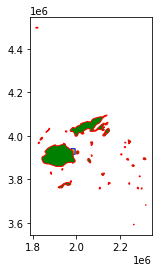

In [12]:
world = gpd.read_file('/home/jovyan/TM_WORLD_BORDERS.geojson') # load world borders
world = world[world['NAME'] == 'Fiji'] # don't care about antarctica...
world = world[['NAME','geometry']].to_crs({"init": "epsg:3460"}) # keep just cols to join/merge

fig, ax = plt.subplots()
overall_aoi_gdf.to_crs({"init": "epsg:3460"}).plot(facecolor="y",edgecolor="b", ax=ax);
world.to_crs({"init": "epsg:3460"}).plot(facecolor="g",edgecolor="r", ax=ax);

# **VAR - Year**

In [13]:
year = ("2013-01-01","2014-01-01")
year = ("2014-01-01","2015-01-01")

# **VAR - i/o DIRS**

In [14]:
d1 = year[0].replace('-','')
d2 = year[1].replace('-','')

inter_dir = './'
scene_nm = f'wofssummary_{d1}_{d2}'
inter_prodir = inter_dir + scene_nm + '/'
os.makedirs(inter_prodir, exist_ok=True)

inter_prodir

'./wofssummary_20140101_20150101/'

# **FIX - Products + Measurements**

masks to consider - will eventually need alternatives for ML-based summaries...

In [15]:
# interested in any landsat water products; nb individual per-scene LS8 masks of dubious quality. 
# Should include S2 and S1 for operational version.
products = [
            "ls8_water_classification",
            "ls7_water_classification",
            "ls5_water_classification",
            "ls4_water_classification"
           ]
measurements = ["water"]

# **FIX - Res + Proj**

In [16]:
resolution = (-30,30)
output_crs = "EPSG:3460"

# **Lazy-load Water Masks & Delayed Processing**

In [17]:
product_data = []
for product in products:
    ds = dc.load(
        product=product,
        time=year, 
        lat=latitude,
        lon=longitude,
        output_crs=output_crs,
        resolution=resolution,
        measurements = measurements,
        group_by='solar_day',
        dask_chunks={
            'time': 1,
            'x': 2202,            
            'y': 2416,
        }
    )
    if ds != None:
        good_quality = (
        (ds.water >= 0) # no data
        )
        ds = ds.where(good_quality)
        product_data.append(ds)
water_dataset = xr.concat(product_data, dim='time').sortby('time')
water_dataset.nbytes/1000000000, water_dataset

(0.19831588,
 <xarray.Dataset>
 Dimensions:  (time: 44, x: 662, y: 851)
 Coordinates:
   * y        (y) float64 3.944e+06 3.944e+06 3.944e+06 ... 3.918e+06 3.918e+06
   * x        (x) float64 1.972e+06 1.972e+06 1.972e+06 ... 1.992e+06 1.992e+06
   * time     (time) datetime64[ns] 2014-01-08T22:01:43 ... 2014-12-26T22:00:31
 Data variables:
     water    (time, y, x) float64 dask.array<chunksize=(1, 851, 662), meta=np.ndarray>
 Attributes:
     crs:      EPSG:3460)

lazy computation

In [18]:
%%time
mean_dataset = water_dataset.water.mean(dim='time')
mean_dataset.nbytes/1000000000

CPU times: user 10.3 ms, sys: 0 ns, total: 10.3 ms
Wall time: 9.93 ms


0.004506896

apply mask to 'ocean' based on 1km buffer from stable coastline 
- may not be req once ML-derived masks are generated - depends on non-continental quality

In [19]:
buffer_path = '/home/jovyan/Fiji_1kmBuffer_shp.shp'
shdf = salem.read_shapefile(buffer_path)
mean_dataset.attrs['pyproj_srs'] = str(water_dataset.attrs['crs'])
mean_dataset = mean_dataset.salem.roi(shape=shdf, other=1)
mean_dataset

<xarray.DataArray 'water' (y: 851, x: 662)>
dask.array<where, shape=(851, 662), dtype=float64, chunksize=(851, 662), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 3.944e+06 3.944e+06 3.944e+06 ... 3.918e+06 3.918e+06
  * x        (x) float64 1.972e+06 1.972e+06 1.972e+06 ... 1.992e+06 1.992e+06
Attributes:
    pyproj_srs:  +proj=tmerc +lat_0=-17 +lon_0=178.75 +k=0.99985 +x_0=2000000...

In [20]:
%%time
## Prepare water pc
T0_nd_water = np.isnan(mean_dataset) # nodata mask
water_pc = (mean_dataset*100).where((T0_nd_water == False),-9999) # assign nodata vals consistent w/ other prods
water_pc = water_pc.astype(np.int16) # seems most sensible

CPU times: user 16.3 ms, sys: 3.74 ms, total: 20.1 ms
Wall time: 20.1 ms


In [21]:
%%time
## Prepare water_no
cnt = water_dataset.water.count(dim='time')
print(cnt.nbytes/1000000000)
water_no = cnt.astype(np.int16) # seems most sensible

0.004506896
CPU times: user 16.3 ms, sys: 15 µs, total: 16.4 ms
Wall time: 23.8 ms


In [22]:
%%time
## Prepare water mask
waterpres_prob = 0.3
T0_nd_water = np.isnan(mean_dataset)
T0_water = mean_dataset.where((mean_dataset < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
T0_water = T0_water.where((T0_water >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water

CPU times: user 34.7 ms, sys: 0 ns, total: 34.7 ms
Wall time: 46.4 ms


In [23]:
%%time
## Compute water_pc and water_no at the same time.
## Also compute intermediaries for plotting.
water_pc_comp, water_no_comp, T0_water_comp, cnt_comp = dask.compute(water_pc, water_no, T0_water, cnt)

CPU times: user 1.03 s, sys: 39.3 ms, total: 1.06 s
Wall time: 11.4 s


# **OUT - Water Persistence - _pc**

In [21]:
## Save
water_pc_ds = water_dataset.isel(time = 0).drop(['time','water']) # easiest to cp attrs etc
water_pc_ds['water_pc'] = water_pc_comp # drop in data
out_ds = inter_prodir + scene_nm + '_pc.tif'
export_xarray_to_geotiff(water_pc_ds, out_ds, bands=['water_pc'], crs=output_crs, x_coord='x', y_coord='y', no_data=-9999)

out_ds, water_pc_ds

('./wofssummary_20140101_20150101/wofssummary_20140101_20150101_pc.tif',
 <xarray.Dataset>
 Dimensions:   (x: 4403, y: 4831)
 Coordinates:
   * x         (x) float64 1.946e+06 1.946e+06 1.946e+06 ... 2.078e+06 2.078e+06
   * y         (y) float64 4.03e+06 4.03e+06 4.03e+06 ... 3.886e+06 3.885e+06
 Data variables:
     water_pc  (y, x) int16 100 100 100 100 100 100 ... 100 100 100 100 100 100
 Attributes:
     crs:      EPSG:3460)

# **OUT - Water Mask - _ma**
- not exported+indexed atm as can be done on the fly

In [22]:
%%time
waterpres_prob = 0.3
T0_nd_water = np.isnan(mean_dataset)
T0_water = mean_dataset.where((mean_dataset < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
T0_water = T0_water.where((T0_water >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water

CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 16.4 ms


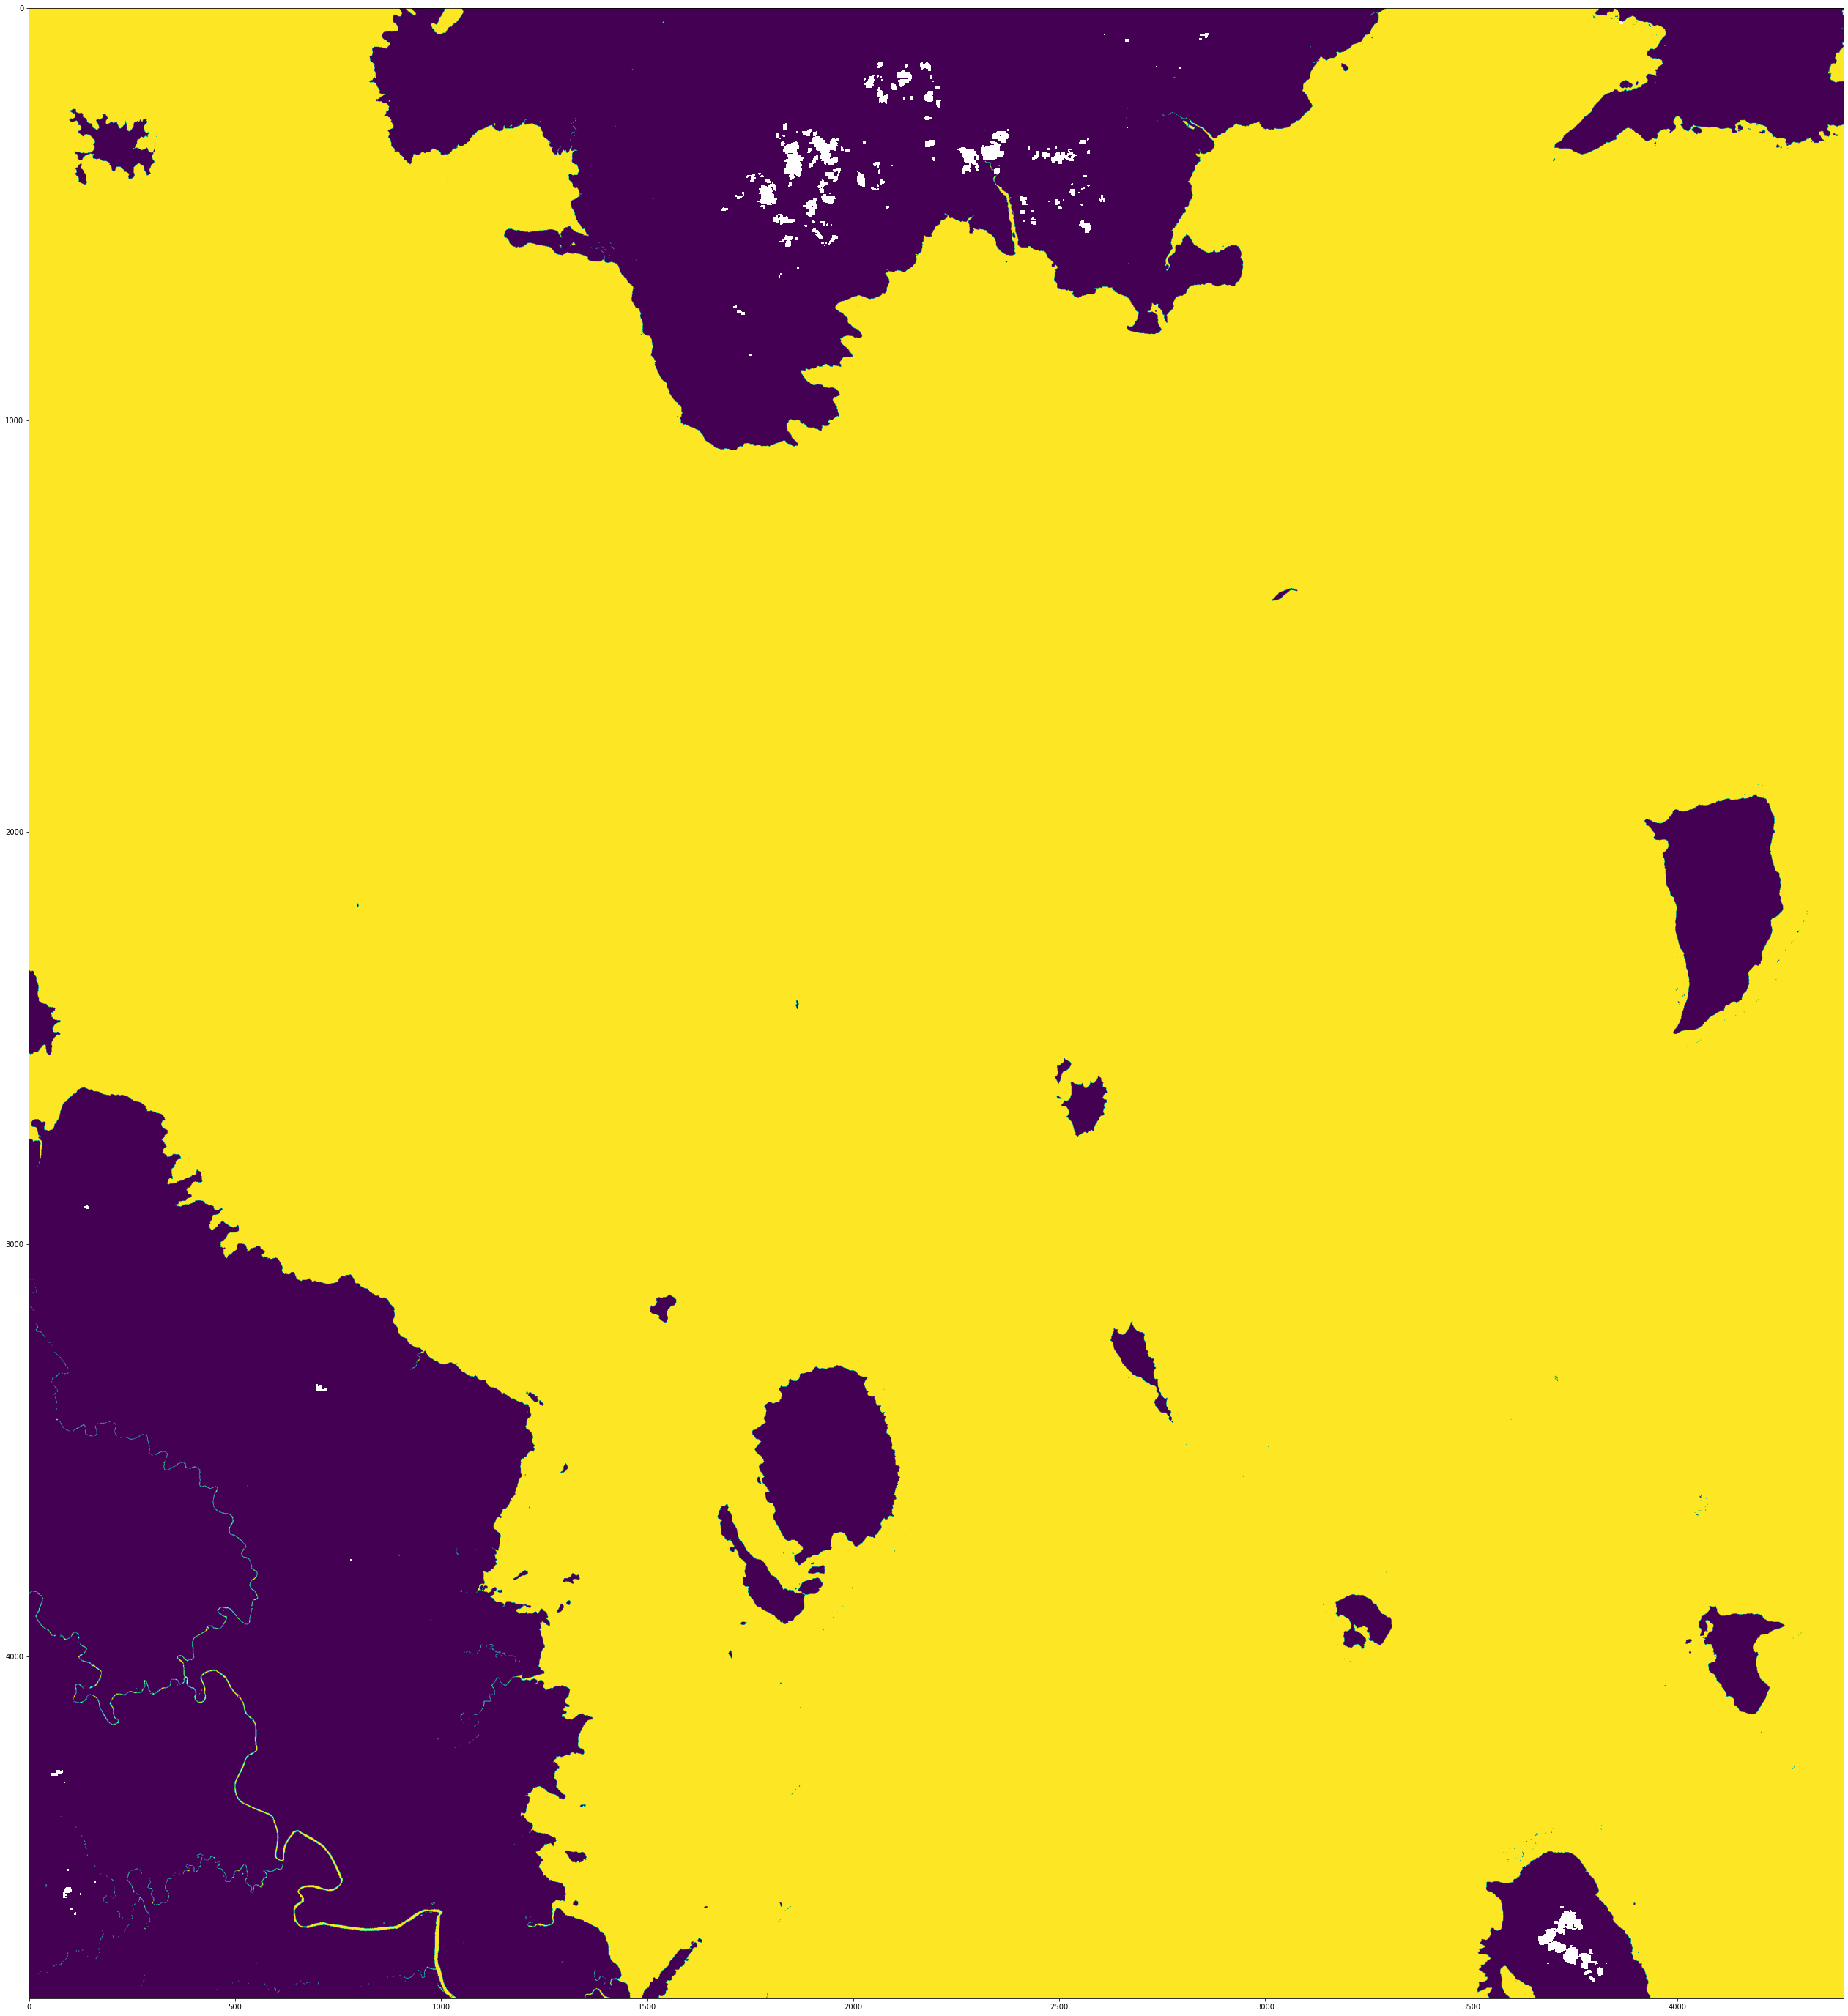

In [23]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(T0_water_comp)

# **OUT - Number of Valid Observations - _no**

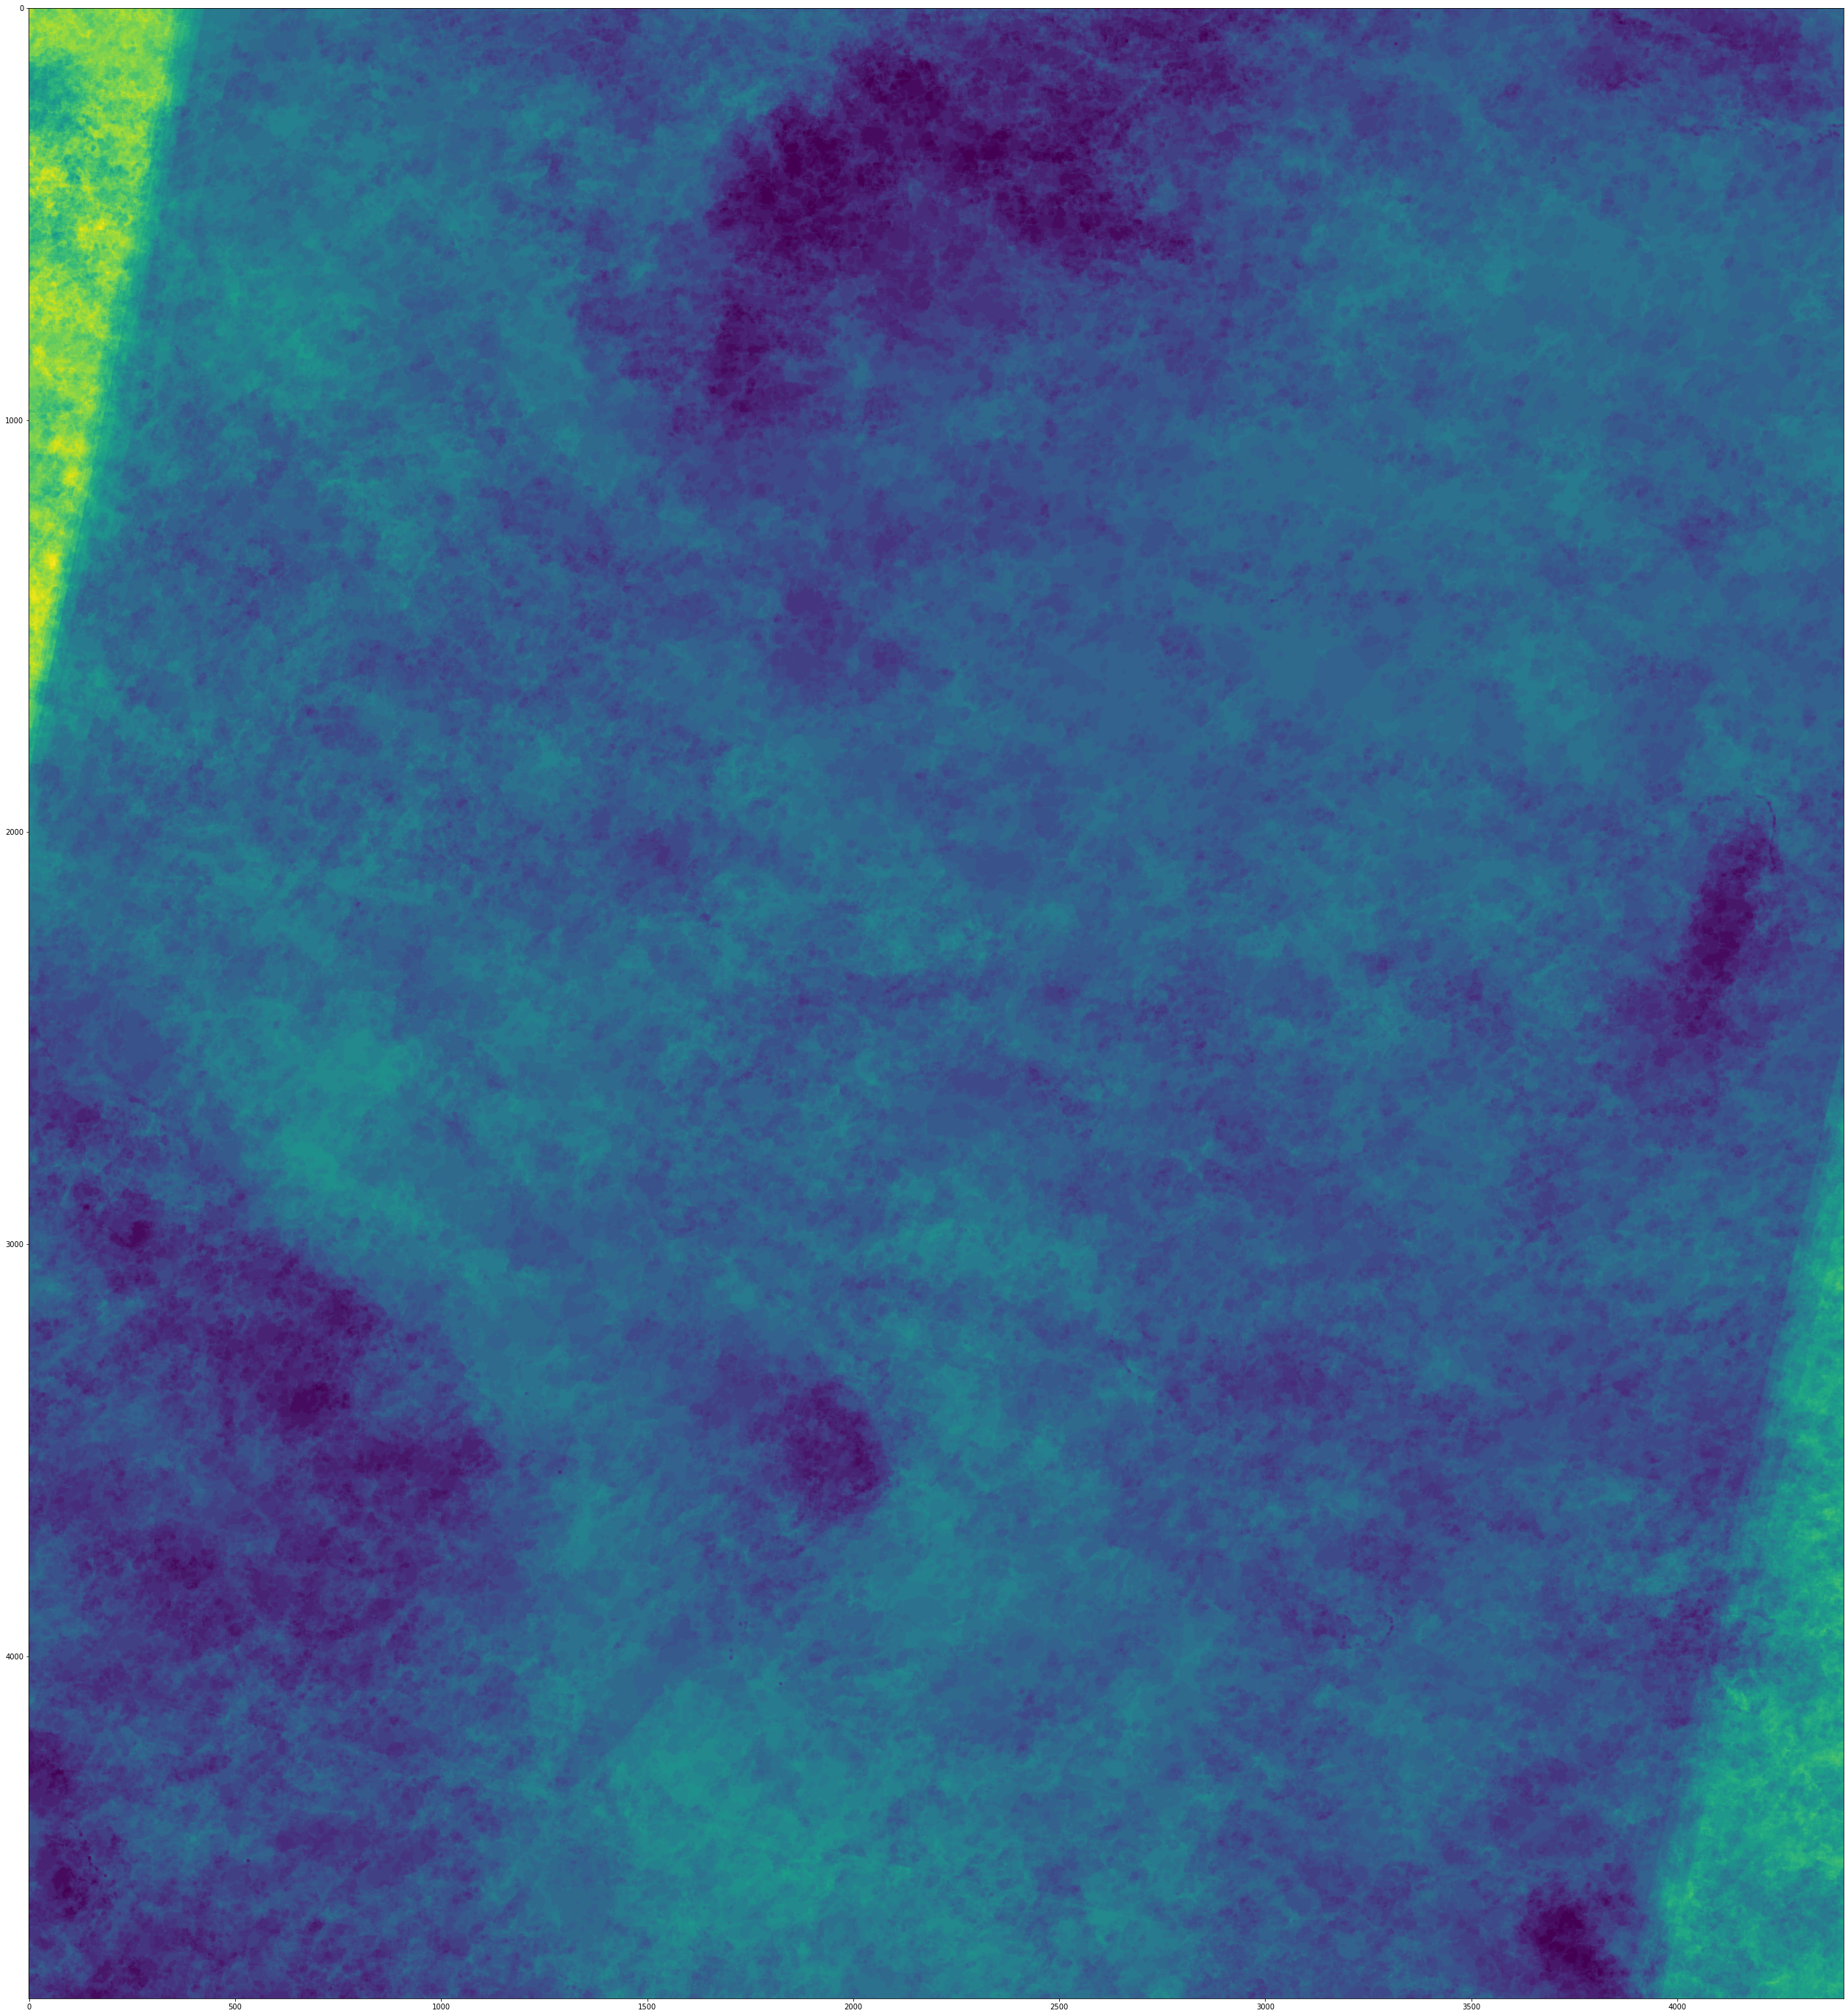

In [24]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(cnt_comp)

In [25]:
%%time
## Save
water_no_ds = water_dataset.isel(time = 0).drop(['time','water']) # easiest to cp attrs etc
water_no_ds['water_no'] = water_no_comp # drop in data
out_ds = inter_prodir + scene_nm + '_no.tif'
export_xarray_to_geotiff(water_no_ds, out_ds, bands=['water_no'], crs=output_crs, x_coord='x', y_coord='y', no_data=-9999)

out_ds, water_no_ds

CPU times: user 59.6 ms, sys: 71.9 ms, total: 132 ms
Wall time: 131 ms


# **OUT - Create Yaml**

In [ ]:
def yaml_prep_wofssummary(scene_dir,t0,t1):
    """
    Prepare yaml for wofs summary product.
    """
    # scene_name = scene_dir.split('/')[-2][:26]
    scene_name = scene_dir.split('/')[-2]
    print ( "Preparing scene {}".format(scene_name) )
    print ( "Scene path {}".format(scene_dir) )
    
    # find all cog prods
    prod_paths = glob.glob(scene_dir + '*wofssummary*.tif') # nb changed to watersummary for ml-driven
    # print ( 'paths: {}'.format(prod_paths) )
    for i in prod_paths: print ( i )
    
    # date time assumed eqv for start and stop - this isn't true and could be 
    # pulled from .xml file (or scene dir) not done yet for sake of progression
#     t0=parse(str(datetime.strptime(original_yml['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')))
    t0=t0
    # print ( t0 )
    t1=t1
    # print ( t1 )
    
    # name image product
    images = {
        prod_path.split('_')[-1][:2]: {                        # TO DO
            'path': str(prod_path.split('/')[-1])
        } for prod_path in prod_paths
    }
    print ( images )

    # trusting bands coaligned, use one to generate spatial bounds for all
    projection, extent = get_geometry(os.path.join(str(scene_dir), images['pc']['path']))
#     extent = 
    print(projection, extent)
    
    new_id = str(uuid.uuid5(uuid.NAMESPACE_URL, f"{scene_name}"))
    
    return {
        'id': new_id,
        'processing_level': "na",
        'product_type': "wofs_summary", # nb changed to water_summary for ml-driven
        'creation_dt': str(datetime.today().strftime('%Y-%m-%d %H:%M:%S')),
        'platform': {  
            'code': "WOFS_SUMMARY" # # nb changed to WATER_SUMMARY for ml-driven
        },
        'instrument': {
            'name': 'na'
        },
        'extent': {
            'coord': extent,
            'from_dt': str(t0),
            'to_dt': str(t1),
            'center_dt': str(t0 + (t1 - t0) / 2)
        },
        'format': {
            'name': 'GeoTiff'
        },
        'grid_spatial': {
            'projection': projection
        },
        'image': {
            'bands': images
        },
        'lineage': {
            'source_datasets': 'na',
        }  
    }

In [ ]:
create_yaml(inter_prodir, yaml_prep_wofssummary(inter_prodir, datetime.strptime(d1, "%Y%m%d"), datetime.strptime(d2, "%Y%m%d"))) 

# **OUT - Upload to S3**

In [ ]:
os.environ['AWS_ACCESS_KEY_ID']= "16c353e3c1673eb9556e"
os.environ['AWS_SECRET_ACCESS_KEY']= ""
os.environ['AWS_S3_ENDPOINT_URL']="http://s3-uk-1.sa-catapult.co.uk"
print(os.environ['AWS_ACCESS_KEY_ID'])

In [ ]:
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/fiji/wofs_summary/'

In [ ]:
s3_upload_cogs(glob.glob(f'{inter_prodir}*'), s3_bucket, s3_dir)

# **OUT - Index product**

In [ ]:
cmd = f'python3 ../dataset_index_from_s3_bucket.py {s3_bucket} -p {s3_dir}{scene_nm}/ --endpoint_url="http://s3-uk-1.sa-catapult.co.uk" --unsigned_requests --start_date 1960-01-01 --end_date 2030-01-01'
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
out = p.stdout.read()
print(out)


# **TEST INDEXING HAS WORKED**

In [ ]:
# interested in any landsat water products; nb individual per-scene LS8 masks of dubious quality. 
# Should include S2 and S1 for operational version.
products = [
            "wofs_summary"
           ]
measurements = ["pc","no"]

In [ ]:
resolution = (-30,30)
output_crs = "EPSG:3460"

In [ ]:
product_data = []
for product in products:
    ds = dc.load(
        product=product,
        time=year, 
        lat=latitude,
        lon=longitude,
        output_crs=output_crs,
        resolution=resolution,
        measurements = measurements,
        group_by='solar_day',
        dask_chunks={
            #'time': 1,
            'x': 1000,
            'y': 1000,
        }
    )
#     if ds != None:
#         good_quality = (
#         (ds.water >= 0) # no data
#         )
#         ds = ds.where(good_quality)
    product_data.append(ds)
water_dataset = xr.concat(product_data, dim='time').sortby('time')
water_dataset.nbytes/1000000000, water_dataset

In [ ]:
a = water_dataset.where(water_dataset.pc != -9999)

%%time
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(a.isel(time=0).pc)

In [ ]:
%%time
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(a.isel(time=0).no)